In [1]:
import dbcred
import sys

from hdbcli import dbapi

Mit HANA-DB verbinden

In [2]:
import hana_ml.dataframe as dataframe

# Instantiate connection object
conn = dataframe.ConnectionContext(dbcred.hxehost, dbcred.port, dbcred.user, dbcred.passwd)

Beispieldaten laden

In [3]:
import pandas as pd
df_data = pd.read_csv('usedcarprices.csv', encoding = 'Windows-1252')

In [4]:
df_data.head(5)

Unnamed: 0  CAR_ID VEHICLETYPE  YEAR    GEARBOX   HP  MODEL  KILOMETER  \
0           0       0         NaN  1993     manual    0   golf     150000   
1           1       1       coupe  2011     manual  190    NaN     125000   
2           2       2         suv  2004  automatic  163  grand     125000   
3           3       3  kleinwagen  2001     manual   75   golf     150000   
4           4       4  kleinwagen  2008     manual   69  fabia      90000   

  FUELTYPE  PRICE  
0   petrol    480  
1   diesel  18300  
2   diesel   9800  
3   petrol   1500  
4   diesel   3600

Beispieldaten in die SAP-HANA-DB laden

In [5]:
df_data_forhana = df_data.copy(deep = True)
df_remote = dataframe.create_dataframe_from_pandas(connection_context = conn, 
                                                   pandas_df = df_data_forhana, 
                                                   table_name = 'USEDCARPRICES',
                                                   force = True,
                                                   replace = True)

Replace nan with 0 in numeric columns and '' in string columns.


Column-Definition der HANA-Tabelle anzeigen

In [6]:
df_remote.dtypes()

[('Unnamed: 0', 'INT', 10),
 ('CAR_ID', 'INT', 10),
 ('VEHICLETYPE', 'VARCHAR', 5000),
 ('YEAR', 'INT', 10),
 ('GEARBOX', 'VARCHAR', 5000),
 ('HP', 'INT', 10),
 ('MODEL', 'VARCHAR', 5000),
 ('KILOMETER', 'INT', 10),
 ('FUELTYPE', 'VARCHAR', 5000),
 ('PRICE', 'INT', 10)]

Mit der collect Funktion übertragen wir die Daten von der HANA-DB ins Notebook

In [7]:
df_remote.head(5).collect()

Unnamed: 0  CAR_ID VEHICLETYPE  YEAR    GEARBOX   HP  MODEL  KILOMETER  \
0           0       0              1993     manual    0   golf     150000   
1           1       1       coupe  2011     manual  190            125000   
2           2       2         suv  2004  automatic  163  grand     125000   
3           3       3  kleinwagen  2001     manual   75   golf     150000   
4           4       4  kleinwagen  2008     manual   69  fabia      90000   

  FUELTYPE  PRICE  
0   petrol    480  
1   diesel  18300  
2   diesel   9800  
3   petrol   1500  
4   diesel   3600

Anzahl der Datensätze

In [8]:
df_remote.count()

371528

Beispiel einer Datenfunktion: Höchster Preis

In [9]:
df_remote.agg([('max', 'PRICE', 'MOSTEXPENSIVE')]).collect()

MOSTEXPENSIVE
0     2147483647

### Descriptive statistics¶
HANA berechnet erstellt uns Übersicht über die paltenwerte

In [10]:
df_remote.describe().collect()

column   count  unique  nulls           mean           std     min  \
0   Unnamed: 0  371528  371528      0  185763.500000  1.072510e+05     0.0   
1       CAR_ID  371528  371528      0  185763.500000  1.072510e+05     0.0   
2         YEAR  371528     155      0    2004.577997  9.286660e+01  1000.0   
3           HP  371528     794      0     115.549477  1.921396e+02     0.0   
4    KILOMETER  371528      13      0  125618.688228  4.011234e+04  5000.0   
5        PRICE  371528    5597      0   17295.141865  3.587954e+06     0.0   
6  VEHICLETYPE  371528       9      0            NaN           NaN     NaN   
7      GEARBOX  371528       3      0            NaN           NaN     NaN   
8        MODEL  371528     252      0            NaN           NaN     NaN   
9     FUELTYPE  371528       8      0            NaN           NaN     NaN   

            max    median  25_percent_cont  25_percent_disc  50_percent_cont  \
0  3.715270e+05  185764.0         92881.75          92881.0         185763.5   
1  3.715270e+05  185764.0         92881.75          92881.0         185763.5   
2  9.999000e+03    2003.0          1999.00           1999.0           2003.0   
3  2.000000e+04     105.0            70.00             70.0            105.0   
4  1.500000e+05  150000.0        125000.00         125000.0         150000.0   
5  2.147484e+09    2950.0          1150.00           1150.0           2950.0   
6           NaN       NaN              NaN              NaN              NaN   
7           NaN       NaN              NaN              NaN              NaN   
8           NaN       NaN              NaN              NaN              NaN   
9           NaN       NaN              NaN              NaN              NaN   

   50_percent_disc  75_percent_cont  75_percent_disc  
0         185763.0        278645.25         278645.0  
1         185763.0        278645.25         278645.0  
2           2003.0          2008.00           2008.0  
3            105.0           150.00            150.0  
4         150000.0        150000.00         150000.0  
5           2950.0          7200.00           7200.0  
6              NaN              NaN              NaN  
7              NaN              NaN              NaN  
8              NaN              NaN              NaN  
9              NaN              NaN              NaN

In [11]:
df_remote.describe().select_statement

'SELECT * FROM (SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select \'Unnamed: 0\' as "column", COUNT("Unnamed: 0") as "count", COUNT(DISTINCT "Unnamed: 0") as "unique", SUM(CASE WHEN "Unnamed: 0" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("Unnamed: 0")) as "mean", STDDEV("Unnamed: 0") as "std", MIN("Unnamed: 0") as "min", MAX("Unnamed: 0") as "max", MEDIAN("Unnamed: 0") as "median" FROM (SELECT * FROM "USEDCARPRICES") AS "DT_0" UNION ALL select \'CAR_ID\' as "column", COUNT("CAR_ID") as "count", COUNT(DISTINCT "CAR_ID") as "unique", SUM(CASE WHEN "CAR_ID" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("CAR_ID")) as "mean", STDDEV("CAR_ID") as "std", MIN("CAR_ID") as "min", MAX("CAR_ID") as "max", MEDIAN("CAR_ID") as "median" FROM (SELECT * FROM "USEDCARPRICES") AS "DT_0" UNION ALL select \'

### Modellübersicht

In [12]:
top_n = 5
df_pushdown_col_frequency = df_remote.agg([('count', 'MODEL', 'COUNT')],  group_by = 'MODEL')
df_col_frequency = df_pushdown_col_frequency.sort('COUNT', desc = True).head(top_n).collect()
df_col_frequency

MODEL  COUNT
0   golf  30070
1  Other  26400
2    3er  20567
3         20484
4   polo  13092

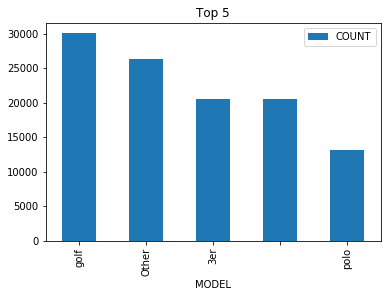

In [13]:
%matplotlib inline
df_col_frequency.plot.bar(x = 'MODEL',
                          y = 'COUNT',
                          title = 'Top 5') ;

### Preis/Jahr analyse
Wir verwenden 1% der Daten für das Training

In [14]:
from hana_ml.algorithms.pal import partition
df_pushdown_sample, df_pushdown_ignore1, df_pushdown_ignore2 = partition.train_test_val_split(
                               conn_context = conn, 
                               data = df_remote, 
                               random_seed = 4242,
                               training_percentage = 0.01, 
                               testing_percentage = 0.99, 
                               validation_percentage = 0)

In [15]:
df_pushdown_sample.head(5).collect()

Unnamed: 0  CAR_ID VEHICLETYPE  YEAR GEARBOX   HP MODEL  KILOMETER  \
0       85409   85409   limousine  2000  manual  204  golf     150000   
1      125994  125994   limousine  2000  manual  105  golf     150000   
2      187092  187092   limousine  1999  manual   75  golf     150000   
3      223002  223002   limousine  2000  manual   75  golf     150000   
4      254098  254098   limousine  1993  manual   60  golf     150000   

  FUELTYPE  PRICE  
0   petrol   4000  
1   petrol   1999  
2   petrol    950  
3   petrol   1900  
4   petrol    500

Uns interessiert nur PRICE und YEAR

In [16]:
col_name_1 = 'PRICE'
col_name_2 = 'YEAR'
df_sample = df_pushdown_sample.select(col_name_1, col_name_2).collect()

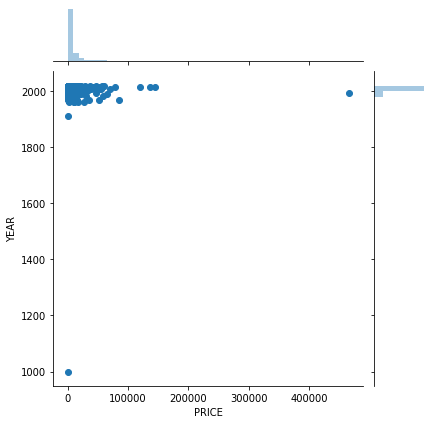

In [18]:
%matplotlib inline
import seaborn as sns
sns.jointplot(x=col_name_1, y=col_name_2, data=df_sample);